In [7]:
import numpy as np
import pandas as pd
import pycountry

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.ticker as ticker

import os
from pathlib import Path

root = Path.cwd() / 'egs_cost_data'

In [8]:
cdf = pd.concat([pd.read_csv(root / f"egs_costs_s_72_{year}.csv").set_index("name")[["capex_mean"]]
           .rename(columns={"capex_mean": year})
            for year in range(2020, 2055, 5)], axis=1)

cdf = cdf.loc[~cdf[2030].isna()]

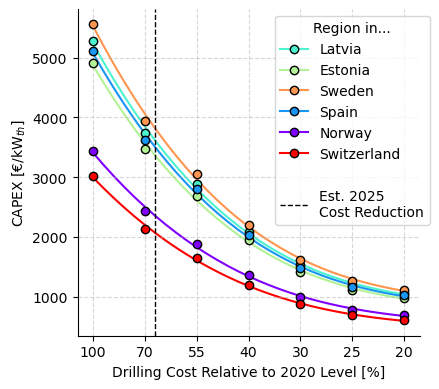

In [24]:
x = np.arange(cdf.columns[0], cdf.columns[-1]+1, 1, dtype=int)

n = 6
colors = cm.rainbow(np.linspace(0, 1, n))
np.random.shuffle(colors)

fig, ax = plt.subplots(figsize=(4.5, 4))

handles = []
labels = []

for c, bus in zip(colors, cdf.sample(n).index):

    fit = np.polyfit(cdf.columns, cdf.loc[bus], 3)

    ax.plot(x, np.polyval(fit, x), color=c, label=bus, zorder=0)
    
    ax.scatter(cdf.columns, cdf.loc[bus], marker="o", color=c, edgecolor="k")

    handles.append(plt.Line2D([0], [0], marker="o", color=c, markerfacecolor=c, markersize=6, markeredgecolor="k"))
    labels.append(pycountry.countries.get(alpha_2=bus[:2]).name)


ax.grid(True, linestyle="--", alpha=0.5)
ax.set_axisbelow(True)

ax.set_ylabel(r"CAPEX [€/kW$_{th}$]")
ax.set_xlabel("Cost Reduction Year")

ax.xaxis.set_major_locator(ticker.FixedLocator(cdf.columns.tolist()))

ax.set_xlabel("Drilling Cost Relative to 2020 Level [%]")

ax.set_xlim(ax.get_xlim())
ax.set_xticklabels(['100', '70', '55', '40', '30', '25', '20'])

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

mark_value = 20

x_pos = cdf.columns[0] + mark_value/100 * (cdf.columns[-1] - cdf.columns[0])
ax.axvline(x_pos, color="k", linestyle="--", linewidth=1)

handles.append(plt.Line2D([0], [0], color="w", linestyle="--", linewidth=0.5))
labels.append(f"")

handles.append(plt.Line2D([0], [0], color="k", linestyle="--", linewidth=1))
labels.append(f"Est. 2025\nCost Reduction")

handles.append(plt.Line2D([0], [0], color="k", linestyle="--", linewidth=0.5))
ax.legend(
    handles, labels, loc="upper right", bbox_to_anchor=(1.05, 1), title="Region in..."
)

plt.tight_layout()
plt.savefig("schematic_cost_reduction.pdf")
plt.show()